<a href="https://colab.research.google.com/github/carynpialat/climate_change_belief_analysis/blob/master/Copy_of_Classifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import spacy
!pip install vaderSentiment
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# For precision, recall, etc.
from sklearn.metrics import classification_report, accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 133kB 2.8MB/s 


In [2]:
# importing vader

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# because it is too big to write out the whole thing, we save it in a shorter 
# variable
analyser = SentimentIntensityAnalyzer()

In [3]:
# Importing data
nlp = spacy.load('en_core_web_sm')
dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

Perusing the data set

> 



In [4]:
#looking at what the data looks like
dftrain.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


By calling .info() some of the observations are that there are no null values and missing data. Also it can be noted that there are integers and objects in the data set. The text data is intuitively the object data. 

In [5]:
#more details on rows and columns
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


one tweetid with null... WHY?


We are able to see that the number of rows vs the number of unique tweet ids, they are the same, it is logical to use the tweet id as the index because is a unique number assigned to each tweet

In [6]:
#tweetid unique count, considering making it the index column
dftrain['tweetid'].nunique()

15819

In [7]:
# setting the tweet ID as index
dftrain.set_index('tweetid', inplace=True) 
dftest.set_index('tweetid', inplace=True)

In [8]:
dftrain.isnull().sum()

sentiment    0
message      0
dtype: int64

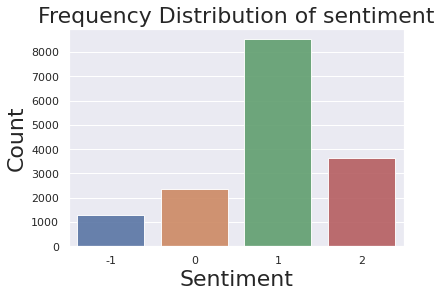

In [9]:
# bar graph showing the sentiment
sentiment_count = dftrain['sentiment'].value_counts()
sns.set(style="darkgrid")
sns.barplot(sentiment_count.index, sentiment_count.values, alpha=0.9)
plt.title('Frequency Distribution of sentiment', fontsize=22)
plt.ylabel('Count', fontsize=22)
plt.xlabel('Sentiment', fontsize=22)
plt.show()

In [10]:
# Percentage of the total rows
sentiment_count/15819*100

 1    53.922498
 2    23.010304
 0    14.874518
-1     8.192680
Name: sentiment, dtype: float64

In [11]:
# Checking the average words in a tweet
num_words = dftrain['message'].apply(lambda x: len(x.split()))
num_words_mean, num_words_std = np.mean(num_words), np.std(num_words)

# checking the average sentences in a tweet
num_sentences = dftrain['message'].apply(lambda x: len(re.split( '~ ...' ,'~'.join(x.split('.')))))
num_sentences_mean = np.mean(num_sentences)

In [12]:
# The average number of words per message/tweet
num_words_mean

17.685062266894242

In [13]:
# The standard deviation of words
num_words_std

4.443768113870797

In [14]:
# The average sentences per message/tweet
num_sentences_mean

1.4003413616537075

Dealing with capitalisation of words

In online posts and messages, it is general practice to use capitalisation to indicate anger or emphasise the content. In order to find out if this holds true to this dataset, an investigation has to be conducted using "vader". This will help in creating a more accurate model as to whether the capitalisation should be left as capitals or changed to small letters.

http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

In [15]:
# creating a function to show which tweets have upper case and which do not
dftrain['upper'] = dftrain['message'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
dftrain.head(20)

,sentiment,message,upper
tweetid,,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...,1
126103,1,It's not like we lack evidence of anthropogeni...,0
698562,2,RT @RawStory: Researchers say we have three ye...,1
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,1
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",1
425577,1,Worth a read whether you do or don't believe i...,0
294933,1,RT @thenation: Mike Pence doesn’t believe in g...,1
992717,1,RT @makeandmendlife: Six big things we can ALL...,2
664510,1,@AceofSpadesHQ My 8yo nephew is inconsolable. ...,0


In [16]:
# what percentage of our tweets have upper case words
x= dftrain['upper'].loc[dftrain['upper'] == 1].count()/15819*100
print(x)

51.41917946772868


In [17]:
def get_sentiment(row,**kwargs):
  # Checking for polarity in the tweets
 sentiment_score = analyser.polarity_scores(row)
 positive_meter = round((sentiment_score['pos'] * 10), 2)
 negative_meter = round((sentiment_score['neg'] * 10), 2)
 return positive_meter if kwargs['k'] == 'positive' else negative_meter
# creating new columns which display our negative and positive
dftrain['positive'] = dftrain['message'].apply(get_sentiment, k='positive')
dftrain['negative'] = dftrain['message'].apply(get_sentiment, k='negative')

for index, row in dftrain.iterrows(): 
   print("Positive : {}, Negative : {}".format(row['positive'], row['negative']))
dftrain.head()

Streaming output truncated to the last 5000 lines.
Positive : 1.61, Negative : 0.9
Positive : 1.45, Negative : 1.05
Positive : 1.94, Negative : 0.0
Positive : 0.0, Negative : 0.0
Positive : 2.46, Negative : 0.0
Positive : 0.0, Negative : 0.0
Positive : 1.68, Negative : 2.0
Positive : 3.75, Negative : 0.0
Positive : 0.0, Negative : 0.0
Positive : 0.0, Negative : 0.0
Positive : 2.34, Negative : 0.0
Positive : 0.0, Negative : 1.93
Positive : 0.0, Negative : 0.0
Positive : 2.15, Negative : 0.0
Positive : 1.18, Negative : 1.71
Positive : 2.06, Negative : 0.0
Positive : 0.0, Negative : 0.0
Positive : 0.0, Negative : 0.95
Positive : 2.28, Negative : 0.0
Positive : 0.0, Negative : 0.0
Positive : 0.0, Negative : 1.23
Positive : 0.84, Negative : 1.28
Positive : 0.0, Negative : 0.91
Positive : 0.0, Negative : 2.41
Positive : 0.85, Negative : 0.0
Positive : 0.87, Negative : 2.69
Positive : 0.0, Negative : 1.12
Positive : 1.39, Negative : 0.0
Positive : 0.0, Negative : 1.71
Positive : 2.41, Negativ

,sentiment,message,upper,positive,negative
tweetid,,,,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...,1,0.95,0.00
126103,1,It's not like we lack evidence of anthropogeni...,0,2.81,1.67
698562,2,RT @RawStory: Researchers say we have three ye...,1,0.00,0.00
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,1,0.00,2.18
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",1,0.00,2.86


In [18]:
dftrain.tail()

,sentiment,message,upper,positive,negative
tweetid,,,,,
22001,1,RT @ezlusztig: They took down the material on ...,3,1.45,0.00
17856,2,RT @washingtonpost: How climate change could b...,1,0.00,0.00
384248,0,notiven: RT: nytimesworld :What does Trump act...,1,0.00,0.00
819732,-1,RT @sara8smiles: Hey liberals the climate chan...,1,0.00,1.98
806319,0,RT @Chet_Cannon: .@kurteichenwald's 'climate c...,1,0.00,0.00


retweets dont get a positive or negative score attached to them...?

In [19]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [21]:
dftrain.tail()

,sentiment,message,upper,positive,negative
tweetid,,,,,
22001,1,RT @ezlusztig: They took down the material on ...,3,1.45,0.00
17856,2,RT @washingtonpost: How climate change could b...,1,0.00,0.00
384248,0,notiven: RT: nytimesworld :What does Trump act...,1,0.00,0.00
819732,-1,RT @sara8smiles: Hey liberals the climate chan...,1,0.00,1.98
806319,0,RT @Chet_Cannon: .@kurteichenwald's 'climate c...,1,0.00,0.00


Working with the urls.

Because of fake news and propaganda, an interesting feature would be to identify and separate the fake news websites from the genuine ones. Especially regarding such a scientific and evidence based subject matter like global warming. In the age of information, there is a lot of misinformation which is being spread on social media.




1.   First, create a dictionary with all the urls 
2.   Separate the fake from the genuine




How to spot fake websites, according to this article, they have strange endings to mimmick the authentic websites (e.g. com.co or com.lo)
http://library.pfeiffer.edu/Fake-News-Worksheet.pdf

In [ ]:
all_news = dftrain['message'].loc[dftrain['sentiment'] == 2]

In [ ]:
all_news.loc[dftrain['message']=='@']

Series([], Name: message, dtype: object)

It is prudent to remove stop words because they are adding unnecessary characters to the text data. 

In [ ]:
from nltk.corpus import stopwords

# Apply this code to every textual string
word_list = message.split() 
filtered_words = [word for word in word_list if word not in stopwords.words('english')]
message = ' '.join(filtered_words)

Pre-processing

In [ ]:
# labels
y = dftrain['sentiment']

# features
X = dftrain.drop('sentiment', axis=1)

In [ ]:
# Transforming the Features
X_transformed = pd.get_dummies(X, drop_first=True)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=50)

Training data

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr1= LogisticRegression()
lr1.fit(X_transformed, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr.intercept_[0]

-0.8709413348874061

In [ ]:
# Predicting the model
pred_lr = lr.predict(X_test)
#pred_lr1= lr1.predict(dftest)

Assessing the model

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, pred_lr)
labels = ['-1: Anti', '0: Neutral', '1: Pro', '2: News']

pd.DataFrame(data=confusion_matrix(y_test, pred_lr), index=labels, columns=labels)

,-1: Anti,0: Neutral,1: Pro,2: News
-1: Anti,13,0,241,0
0: Neutral,0,15,442,0
1: Pro,0,0,1736,0
2: News,0,0,692,25


In [ ]:
# Classification report
print('Classification Report')
print(classification_report(y_test, pred_lr, target_names=['-1: Anti', '0: Neutral', '1: Pro', '2: News']))

Classification Report
              precision    recall  f1-score   support

    -1: Anti       1.00      0.05      0.10       254
  0: Neutral       1.00      0.03      0.06       457
      1: Pro       0.56      1.00      0.72      1736
     2: News       1.00      0.03      0.07       717

    accuracy                           0.57      3164
   macro avg       0.89      0.28      0.24      3164
weighted avg       0.76      0.57      0.43      3164



In [ ]:
accuracy_score(y_test, pred_lr) 

0.5654235145385588